In [6]:
import numpy as np
g = 1
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
import matplotlib.colors as mcolors

# Code

In [98]:
def exact_solver(ql, qr, g = 9.81, velocity=True):
      """ 
      computes the solution to Riemann problem
      provides the following elements:
      - type: the type of specific solutions: 'wet' for wet bed, 'dry-cavity' for dry cavity, 
              'dry-left' for a dry initial state on the left, and 'dry-right' for a dry 
              initial state on the right. '1-rarefaction' is the left and right states 
              lie on the 1-integral curve, the same applies for '2-rarefaction', '1-shock'
              and '2-shock'
      - structure: the nature of each wave ('shock', 'rarefaction', or 'contact') composing the solution
      - solution: solution(xi) is the solution to the Riemann problem with xi = x/t 
                  solution(xi)[0] is depth
                  solution(xi)[1] is velocity if the Boolean velocity is set to True
                  solution(xi)[1] is momentum if the Boolean velocity is set to False
      - speeds: speeds of each wave. Initially, it is set to [0,0,0,0,0] (there are at most five 
                significant wave speeds to fully describe the solution), and each speed is set to a different
                value depending on the wave structure
      - hm, um: depth and velocity of the intermediate state if it exists. Initially they are set to 0, 0.
      """
      from scipy.optimize import fsolve
      # determines the depth and velocity of the
      # right and left states
      # if velocity is set to True, then q = (h, u)
      # if velocity is set to False, then q = (h, hu)
      if velocity:
            hl, ul = ql
            hul = hl*ul
            hr, ur = qr
            hur = hr*ur
      else:
            hl, hul = ql
            hr, hur = qr
            if hl>0:
                  ul = hul/hl
            else:
                  hl = 0
                  ul = 0
            if hr>0:
                  ur = hur/hr
            else:
                  hr = 0
                  ur = 0
      # left and right velocities
      cl = np.sqrt(g*hl)
      cr = np.sqrt(g*hr)
      # velocity jump
      delta_u  = ur-ul
      # critical velocity for depth positivity condition
      delta_cr = 2*(cl+cr)
      structure= ['none']
      hm = 0
      um = 0
      # initialization of speeds
      speeds = np.zeros(5)
      # solution type
      if delta_u<delta_cr:
            type='wet'
      else:
            type='dry-cavity'
            structure = ['rarefaction','rarefaction']
      if hl==0:
                  type='dry-left'
                  structure = ['contact','rarefaction']
                  speeds[0] = ur-2*cr
                  speeds[1] = ul+cr

      elif hr==0:
                  type='dry-right'
                  structure = ['rarefaction','contact']
                  speeds[0] = ul-cl
                  speeds[1] = ul+2*cl
      # functions used for defining integral curves and Hugoniot loci
      def fl(h):
            if h<=hl:
                  return 2*(np.sqrt(g*h)-cl)
            else:
                  return (h-hl)*np.sqrt(g/2*(1/h+1/hl))
      def fr(h):
            if h<=hr:
                  return 2*(np.sqrt(g*h)-cr)
            else:
                  return (h-hr)*np.sqrt(g/2*(1/h+1/hr))
      def fl_der(h):
            if h<=hl:
                  return g/np.sqrt(g*h) 
            else:
                  return np.sqrt(g/2*(1/h+1/hl))-g*(h-hl)/4/h**2/np.sqrt(g/2*(1/h+1/hl))
      def fr_der(h):
            if h<=hr:
                  return g/np.sqrt(g*h) 
            else:
                  return np.sqrt(g/2*(1/h+1/hr))-g*(h-hr)/4/h**2/np.sqrt(g/2*(1/h+1/hr))
      # Test whether the L and R states are connected by a single 1-rarefaction or 1-shock wave
      if hl>0 and hr>0:
            if ur == ul-fl(hr):
                  if hr<hl:  
                        type = '1-rarefaction'
                        structure = ['rarefaction','contact']
                        speeds[0] = ul-cl
                        speeds[1] = ur-cr
                  if hr>=hl: 
                        type = '1-shock'
                        structure = ['shock','contact']
                        speeds[0] = (hur-hul)/(hr-hl)
      # Test whether the L and R states are connected by a single 2-rarefaction or 2-shock wave
            if ul == ur+fr(hl):
                  if hl<hr:  
                        type = '2-rarefaction'
                        structure = ['contact','rarefaction']
                        speeds[0] = ul+cl
                        speeds[1] = ur+cr
                  if hl>=hr: 
                        type = '2-shock'
                        structure = ['contact','shock']
                        speeds[0] = (hur-hul)/(hr-hl)
      # Otherwise, the L and R states are connected by two waves
      if type == 'wet':
            # determines the intermediate state
            f     = lambda h: fl(h)+fr(h)+delta_u
            f_der = lambda h: fl_der(h)+fr_der(h) 
            # guess value (Toro, eq. (5.24))
            guess =((cl+cr)/2-delta_u/4)**2/g
            #print('guess = {:.2f}'.format(guess))
            hm, _, ier, msg = fsolve(f,guess,fprime=f_der, full_output=True, xtol=1.e-12)
            if ier != 1:
                  print(msg)
            hm = hm[0]
            um = (ul+ur)/2+(fr(hm)-fl(hm))/2
            hum= um*hm
            cm = np.sqrt(g*hm)
            h0 = min(hr, hl)
            h1 = max(hr, hl)
            if 0 < hm <= h0: 
                  structure = ['rarefaction','rarefaction']
                  zone      = 5
                  speeds[0] = ul-cl
                  speeds[1] = um-cm
                  speeds[2] = um+cm
                  speeds[3] = ur+cr
            if h0< hm <= h1:
                  zone      = 4
                  if hm < hl:
                        structure = ['rarefaction','shock']
                        speeds[0] = ul-cl
                        speeds[1] = um-cm
                        speeds[2] = (hur-hum)/(hr-hm)
                  if hm > hl:
                        structure = ['shock','rarefaction']
                        speeds[0] = (hul-hum)/(hl-hm)
                        speeds[1] = um+cm
                        speeds[2] = ur+cr
            if h1< hm      : 
                  structure = ['shock','shock']
                  zone      = 3
                  speeds[0] = (hul-hum)/(hl-hm)
                  speeds[1] = (hur-hum)/(hr-hm)
      if type == 'dry-cavity':
            structure = ['rarefaction','rarefaction']
            zone      = 5
            speeds[0] = ul-cl
            speeds[1] = ul+2*cl
            speeds[2] = ur-2*cr
            speeds[3] = ur+cr
      # 1- and 2-rarefaction waves
      def rarefaction_1(xi):
            r1 = ul+2*cl
            u = (2*xi+r1)/3
            h = (r1-xi)**2/9/g
            return h, u
      def rarefaction_2(xi):
            r2 = ur-2*cr
            u = (2*xi+r2)/3
            h = (r2-xi)**2/9/g
            return h, u
      # solution to the Riemann problem 
      def solution(xi):
            #hm, ul = qm
            global hm, um
            if structure == ['shock','contact'] or structure == ['contact','shock']:
                  hsol  = hl*(xi<speeds[0]) + hr*(xi>=speeds[0])
                  usol  = ul*(xi<speeds[0]) + ur*(xi>=speeds[0])
                  husol = usol*hsol
            if structure == ['shock','shock']:
                  hsol  = hl*(xi<speeds[0]) + hm*(xi<speeds[1])*(xi>=speeds[0]) + hr*(xi>=speeds[1])
                  usol  = ul*(xi<speeds[0]) + um*(xi<speeds[1])*(xi>=speeds[0]) + ur*(xi>=speeds[1])
                  husol = usol*hsol
            if structure == ['rarefaction','contact']:
                  hs = rarefaction_1(xi)[0]
                  us = rarefaction_1(xi)[1]
                  hsol  = hl*(xi<speeds[0]) + hs*(xi<speeds[1])*(xi>=speeds[0]) + hr*(xi>=speeds[1])
                  usol  = ul*(xi<speeds[0]) + us*(xi<speeds[1])*(xi>=speeds[0]) + ur*(xi>=speeds[1])
                  husol = usol*hsol
            if structure == ['contact','rarefaction']:
                  hs = rarefaction_2(xi)[0]
                  us = rarefaction_2(xi)[1]
                  hsol  = hl*(xi<speeds[0]) + hs*(xi<speeds[1])*(xi>=speeds[0]) + hr*(xi>=speeds[1])
                  usol  = ul*(xi<speeds[0]) + us*(xi<speeds[1])*(xi>=speeds[0]) + ur*(xi>=speeds[1])
                  husol = usol*hsol
            if structure == ['rarefaction','shock']:
                  hi = rarefaction_1(xi)[0]
                  ui = rarefaction_1(xi)[1]
                  hsol  = hl*(xi<speeds[0]) + hi*(xi<speeds[1])*(xi>=speeds[0]) + hm*(xi<speeds[2])*(xi>=speeds[1]) + hr*(xi>=speeds[2])
                  usol  = ul*(xi<speeds[0]) + ui*(xi<speeds[1])*(xi>=speeds[0]) + um*(xi<speeds[2])*(xi>=speeds[1]) + ur*(xi>=speeds[2])
                  husol = usol*hsol
            if structure == ['shock','rarefaction']:
                  hi = rarefaction_2(xi)[0]
                  ui = rarefaction_2(xi)[1]
                  hsol  = hl*(xi<speeds[0]) + hm*(xi<speeds[1])*(xi>=speeds[0]) + hi*(xi<speeds[2])*(xi>=speeds[1]) + hr*(xi>=speeds[2])
                  usol  = ul*(xi<speeds[0]) + um*(xi<speeds[1])*(xi>=speeds[0]) + ui*(xi<speeds[2])*(xi>=speeds[1]) + ur*(xi>=speeds[2])
                  husol = usol*hsol
            if structure == ['rarefaction','rarefaction']:
                  hi = rarefaction_1(xi)[0]
                  ui = rarefaction_1(xi)[1]
                  hj = rarefaction_2(xi)[0]
                  uj = rarefaction_2(xi)[1]
                  hsol  = hl*(xi<speeds[0]) + hi*(xi<speeds[1])*(xi>=speeds[0]) + \
                        + hm*(xi<speeds[2])*(xi>=speeds[1]) +  hj*(xi<speeds[3])*(xi>=speeds[2]) + hr*(xi>=speeds[3])
                  usol  = ul*(xi<speeds[0]) + ui*(xi<speeds[1])*(xi>=speeds[0]) + \
                        + um*(xi<speeds[2])*(xi>=speeds[1]) + uj* (xi<speeds[3])*(xi>=speeds[2]) + ur*(xi>=speeds[3])
                  husol = usol*hsol
            if velocity:
                  return hsol, usol
            if not velocity:
                  return hsol, husol
      
      return type, structure, solution, speeds, hm, um

In [112]:
def characteristic(x0, ql, qr, order, g = 9.81, velocity = True):
      """ 
      provides the 1- or 2- characteristic curve:
      characteristic1(t) is the characteristic curve x = f(t | x0, ql, qr, g)
      The Boolean variable velocity is to know whether ql=(hl,ul) [velocity=True] 
      or ql=(hl, ul*hl) [velocity=False]
      """
      if velocity:
            hl, ul = ql
            hul = hl*ul
            hr, ur = qr
            hur = hr*ur
      else:
            hl, hul = ql
            hr, hur = qr
            if hl>0:
                  ul = hul/hl
            else:
                  hl = 0
                  ul = 0
            if hr>0:
                  ur = hur/hr
            else:
                  hr = 0
                  ur = 0
      # left and right velocities
      cl = np.sqrt(g*hl)
      cr = np.sqrt(g*hr)

      _, structure, _, speeds, hm, um = exact_solver(ql,qr,g)
      cm = np.sqrt(g*hm)
      #####################
      # 1-characteristics #
      #####################
      if order == 1:
            if structure == ['shock','contact']:
                  def characteristic1(t):
                        s = speeds[0]
                        lambda_1l = ul-cl
                        lambda_1r = ur-cr
                        if x0>0:
                              t0 = x0/(s-lambda_1r)
                              x  = (x0+lambda_1r*t)*(t<t0)+s*t*(t>=t0)
                        if x0<0:
                              t0 = x0/(s-lambda_1l)
                              x  = (x0+lambda_1l*t)*(t<t0)+s*t*(t>=t0)
                        if x0 == 0:
                              x = s*t
                        return x
            if structure == ['contact','shock']:
                  def characteristic1(t):
                        s = speeds[0]
                        lambda_1r = ur-cr
                        lambda_1l = ul-cl
                        t0 = x0/(s-lambda_1l)
                        a  = s*t0
                        x  = (x0+lambda_1l*t)*(t<t0)+(a+lambda_1r*(t-t0))*(t>=t0)
                        return x
            if structure == ['shock','shock']:
                  cm = np.sqrt(g*hm)
                  s  = speeds[0]
                  w  = speeds[1]
                  lambda_1l = ul-cl
                  lambda_1r = ur-cr
                  lambda_1m = um-cm
                  def characteristic1(t):
                        if x0>0:
                              t0 = x0/(w-lambda_1r)
                              a  = w*t0
                              t1 = (a-lambda_1m*t0)/(s-lambda_1m )
                              x  = (x0+lambda_1r*t)*(t<t0)+(a+lambda_1m*(t-t0))*(t>=t0)*(t<t1)+s*t*(t>=t1)
                        if x0<0:
                              t0 = x0/(s-lambda_1l)
                              x  = (x0+lambda_1l*t)*(t<t0)+s*t*(t>=t0)
                        if x0 == 0:
                              x = s*t
                        return x
            if structure == ['rarefaction','contact']:
                  def characteristic1(t):
                        lambda_1l = ul-cl
                        lambda_1r = ur-cr
                        s0  = speeds[0]
                        s1  = speeds[1]
                        if x0 < 0:
                              x = x0 + lambda_1l * t 
                        if x0 > 0:
                              x = x0 + lambda_1r * t 
                        if x0 == 0:
                              if s0<0 and s1>0:
                                    x = 0*t
                              if s0>0:
                                    x  = x0+lambda_1l * t
                              if s1<0:
                                    x  = x0+lambda_1r * t 
                        return x    
            if structure == ['contact','rarefaction']:
                  def characteristic1(t):
                        s0 = speeds[0]
                        s1 = speeds[1]
                        lambda_1r = ur-cr
                        lambda_1l = ul-cl
                        if x0 < 0:
                              x = x0 + lambda_1l*t
                        if x0 > 0:
                              t1 = x0/(s1 - lambda_1r)
                              r2 = ur-2*cr
                              x1 = s1*t1
                              a  = (x1 - r2*t1)/t1**(1/3)
                              if type == '2-rarefaction':
                                    t2 = (a/(s0-r2))**(3/2)
                                    x2 = t2*s0
                                    x  = (x0+lambda_1r*t)*(t<t1)+ (a*t**(1/3)+r2*t)*(t>=t1)*(t<t2)+(x2 +lambda_1l*(t-t2) )*(t>=t2)
                              else:
                                    x  = (x0+lambda_1r*t)*(t<t1)+(a*t**(1/3)+r2*t)*(t>=t1)
                        if x0 == 0:
                              if s0<0 and s1>0:
                                    x = 0*t
                              if s0>0:
                                    x  = x0+lambda_1l * t
                              if s1<0:
                                    x  = x0+lambda_1r * t 
                        return x
            if structure == ['rarefaction','shock']:
                  def characteristic1(t):
                        s2 = speeds[2]
                        lambda_1r = ur-cr
                        lambda_1l = ul-cl
                        lambda_1m = um-cm
                        if x0 < 0:
                              x = x0 + lambda_1l*t
                        if x0 > 0:
                              t0 = x0/(s2-lambda_1r)
                              x2 = t0*s2
                              x  = (x0 + lambda_1r*t)*(t<t0)+(x2 + lambda_1m*(t-t0))*(t>=t0)
                        if x0 == 0:
                              if s0<0 and s1>0:
                                    x = 0*t
                              if s0>0:
                                    x  = x0+lambda_1l * t
                              if s1<0:
                                    x  = x0+lambda_1r * t
                        return x
            if structure == ['rarefaction','rarefaction'] and type != 'dry-cavity':
                  def characteristic1(t):
                        s2 = speeds[2]
                        s3 = speeds[3]
                        r2 = ur-2*cr
                        lambda_1l = ul-cl
                        lambda_1r = ur-cr
                        lambda_1m = um-cm
                        if x0 < 0:
                              x = x0+lambda_1l * t
                        if x0 > 0:
                              t3 = x0/(s3-lambda_1r)
                              x3 = s3*t3
                              a  = (x3-r2*t3)/t3**(1/3)
                              t2 = (a/(s2-r2))**(3/2)
                              x2 = s2*t2
                              x  = (x0+lambda_1r*t)*(t<t3)+(a*t**(1/3)+r2*t)*(t>=t3)*(t<t2)+(x2+lambda_1m*(t-t2))*(t>=t2)
                        if x0 == 0:
                              x = lambda_1m*t
                        return x
            if type == 'dry-cavity':
                  def characteristic1(t):
                        s3 = speeds[3]
                        r2 = ur-2*cr
                        lambda_1l = ul-cl
                        lambda_1r = ur-cr
                        if x0 < 0:
                              x = x0+lambda_1l * t
                        if x0 > 0:
                              t3 = x0/(s3-lambda_1r)
                              x3 = s3*t3
                              a  = (x3-r2*t3)/t3**(1/3)
                              x  = (x0+lambda_1r*t)*(t<t3)+(a*t**(1/3)+r2*t)*(t>=t3)                                                        
                        if x0 == 0:
                              x =0*t
                        return x
            if structure == ['shock','rarefaction']:
                  def characteristic1(t):
                        s0 = speeds[0]
                        s1 = speeds[1]
                        s2 = speeds[2]
                        r2 = ur-2*cr
                        lambda_1r = ur-cr
                        lambda_1l = ul-cl
                        lambda_1m = um-cm
                        if x0 > 0:
                              t0 = x0/(s2-lambda_1r)
                              a = (s2*t0-r2*t0)/t0**(1/3)
                              t1 = (a/(s1-r2))**(3/2)
                              x1 = s1*t1
                              t2 = (x1-lambda_1m*t1)/(s0-lambda_1m)
                              x = (x0 + lambda_1r*t)*(t<t0)+(a*t**(1/3)+r2*t)*(t<t1)*(t>=t0)+(x1+lambda_1m*(t-t1))*(t>=t1)*(t<t2) + \
                              (s0*t)*(t>=t2)*(t>=t2)
                        if x0 < 0:
                              t0 = x0/(s0-lambda_1l)
                              x  = (x0 + lambda_1l*t)*(t<t0)+(s0*t)*(t>t0)
                        if x0 == 0:
                              x = s0*t
                        return x
      #####################
      # 2-characteristics #
      #####################
      if order == 2:
            if structure == ['shock','contact']:
                  def characteristic1(t):
                        s = speeds[0]
                        lambda_2r = ur+cr
                        lambda_2l = ul+cl
                        if x0 != 0:
                              t0 = x0/(s-lambda_2l)
                              a  = s*t0
                              x  = (x0+lambda_2l*t)*(t<t0)+(a+lambda_2r*(t-t0))*(t>=t0)
                        if x0 == 0:
                              x =  lambda_2r*t
                        return x
            if structure == ['contact','shock']:
                  def characteristic1(t):
                        s = speeds[0]
                        lambda_2l = ul+cl
                        lambda_2r = ur+cr
                        if x0>0:
                              t0 = x0/(s-lambda_2r)
                              x  = (x0+lambda_2r*t)*(t<t0)+s*t*(t>=t0)
                        if x0<0:
                              t0 = x0/(s-lambda_2l)
                              x  = (x0+lambda_2l*t)*(t<t0)+s*t*(t>=t0)
                        if x0 == 0:
                              x =  s*t
                        return x
            
                  
            if structure == ['shock','shock']:
                  cm = np.sqrt(g*hm)
                  s  = speeds[0]
                  w  = speeds[1]
                  lambda_2l = ul+cl
                  lambda_2r = ur+cr
                  lambda_2m = um+cm
                  def characteristic1(t):
                        if x0<0:
                              t0 = x0/(s-lambda_2l)
                              a  = s*t0
                              t1 = (a-lambda_2m*t0)/(w-lambda_2m )
                              x  = (x0+lambda_2l*t)*(t<t0)+(a+lambda_2m*(t-t0))*(t>=t0)*(t<t1)+w*t*(t>=t1)
                        if x0>0:
                              t0 = x0/(w-lambda_2r)
                              x  = (x0+lambda_2r*t)*(t<t0)+w*t*(t>=t0)
                        if x0 == 0:
                              x = s*t
                        return x
            if structure == ['contact','rarefaction']:
                  def characteristic1(t):
                        lambda_2l = ul+cl
                        lambda_2r = ur+cr
                        s  = speeds[0]
                        w  = speeds[1]
                        if x0 < 0:
                              x  = x0+lambda_2l *t 
                        if x0 > 0:
                              x = x0+lambda_2r *t 
                        if x0 == 0:
                              if s<0 and w>0:
                                    x = 0*t
                              if s>0:
                                    x  = x0+lambda_2l *t
                              if s>0:
                                    x  = x0+lambda_2r *t
                        return x
            if structure == ['rarefaction','contact']:
                  def characteristic1(t):
                        s0 = speeds[0]
                        s1 = speeds[1]
                        lambda_2r = ur+cr
                        lambda_2l = ul+cl
                        if x0 < 0:
                              t1 = x0/(s0 - lambda_2l)
                              r1  = ul+2*cl
                              x1  = s0*t1
                              a   = (x1 - r1*t1)/t1**(1/3)
                              if type == '2-rarefaction':
                                    t2 = (a/(s1-r1))**(3/2)
                                    x2  = s1*t2
                                    x   = (x0+lambda_2l*t)*(t<t1)+(a*t**(1/3)+r1*t)*(t>=t1)*(t<t2)+\
                                          (x2+lambda_2r*(t-t2))*(t>t2)
                              else:
                                    x   = (x0+lambda_2l*t)*(t<t1)+(a*t**(1/3)+r1*t)*(t>=t1)
                        if x0 >= 0:
                              x = x0+lambda_2r * t
                        return x
            if structure == ['rarefaction','rarefaction'] and type != 'dry-cavity':
                  def characteristic1(t):
                        s0 = speeds[0]
                        s1 = speeds[1]
                        r1 = ul+2*cl
                        lambda_2l = ul+cl
                        lambda_2r = ur+cr
                        lambda_2m = um+cm
                        if x0 > 0:
                              x = x0+lambda_2r * t
                        if x0 < 0:
                              t0= x0/(s0-lambda_2l)
                              x3 = s0*t0
                              a  = (x3-r1*t0)/t0**(1/3)
                              t1 = (a/(s1-r1))**(3/2)
                              x1 = s1*t1
                              x  = (x0+lambda_2l*t)*(t<t0)+(a*t**(1/3)+r1*t)*(t>=t0)*(t<t1)+(x1+lambda_2m*(t-t1))*(t>=t1)
                        if x0 == 0:
                              x = lambda_2m*t
                        return x
            if type == 'dry-cavity':
                  def characteristic1(t):
                        s0 = speeds[0]
                        s1 = speeds[1]
                        r1 = ul+2*cl
                        lambda_2l = ul+cl
                        lambda_2r = ur+cr
                        if x0 > 0:
                              x = x0+lambda_2r * t
                        if x0 < 0:
                              t0 = x0/(s0-lambda_2l)
                              x3 = s0*t0
                              a  = (x3-r1*t0)/t0**(1/3)
                              x  = (x0+lambda_2l*t)*(t<t0)+(a*t**(1/3)+r1*t)*(t>=t0)
                        if x0 == 0:
                              x = 0*t
                        return x
            if structure == ['rarefaction','shock']:
                  def characteristic1(t):
                        s0 = speeds[0]
                        s1 = speeds[1]
                        s2 = speeds[2]
                        r1 = ul+2*cl
                        lambda_2r = ur+cr
                        lambda_2l = ul+cl
                        lambda_2m = um+cm
                        if x0 < 0:
                              t0 = x0/(s0-lambda_2l)
                              a = (s0*t0-r1*t0)/t0**(1/3)
                              t1 = (a/(s1-r1))**(3/2)
                              x1 = s1*t1
                              t2 = (x1-lambda_2m*t1)/(s2-lambda_2m)
                              x = (x0 + lambda_2l*t)*(t<t0)+(a*t**(1/3)+r1*t)*(t<t1)*(t>=t0)+(x1+lambda_2m*(t-t1))*(t>=t1)*(t<t2) + \
                              (s2*t)*(t>=t2)*(t>=t2)
                        if x0 > 0:
                              t0 = x0/(s2-lambda_2r)
                              x  = (x0 + lambda_2r*t)*(t<t0)+(s2*t)*(t>t0)
                        if x0 == 0:
                              if s0<0 and s1>0:
                                    x = 0*t
                              if s0>0:
                                    x  = x0+lambda_2l * t
                              if s1<0:
                                    x  = s2 * t
                        return x
            if structure == ['shock','rarefaction']:
                  def characteristic1(t):
                        s0 = speeds[0]

                        lambda_2r = ur+cr
                        lambda_2l = ul+cl
                        lambda_2m = um+cm
                        if x0 > 0:
                              x = x0 + lambda_2r*t
                        if x0 < 0:
                              t0 = x0/(s0-lambda_2l)
                              x2 = t0*s0
                              x  = (x0 + lambda_2l*t)*(t<t0)+(x2 + lambda_2m*(t-t0))*(t>=t0)
                        if x0 == 0:
                              x = s0*t
                        return x
      return characteristic1

# Solutions

In [30]:
# functions for defining the integral curves and Hugoniot loci
def phi_l(h):
            if h<=hl:
                  return ul-2*(np.sqrt(g*h)-np.sqrt(g*hl))
            else:
                  return ul-(h-hl)*np.sqrt(g/2*(1/h+1/hl))
            
def phi_r(h):
            if h<=hr:
                  return ur+2*(np.sqrt(g*h)-np.sqrt(g*hr))
            else:
                  return ur+(h-hr)*np.sqrt(g/2*(1/h+1/hr))
            
def phi_lm(h):
            if h<=hm:
                  return um-2*(np.sqrt(g*h)-np.sqrt(g*hm))
            else:
                  return um-(h-hm)*np.sqrt(g/2*(1/h+1/hm))
            
def phi_rm(h):
            if h<=hm:
                  return um+2*(np.sqrt(g*h)-np.sqrt(g*hm))
            else:
                  return um+(h-hm)*np.sqrt(g/2*(1/h+1/hm))           


## 1-Shock

In [118]:
# 1-shock
hl = 2
ul = 1
hr = 3
ur = phi_l(hr)
print(ur)

type, st, sol, sp, hm, um = exact_solver((hl,ul),(hr,ur),g=1)
print((hm, um))
print(type)
print(st)
print(sp)



0.3545027756320972
(0, 0)
1-shock
['shock', 'contact']
[-0.93649167  0.          0.          0.          0.        ]


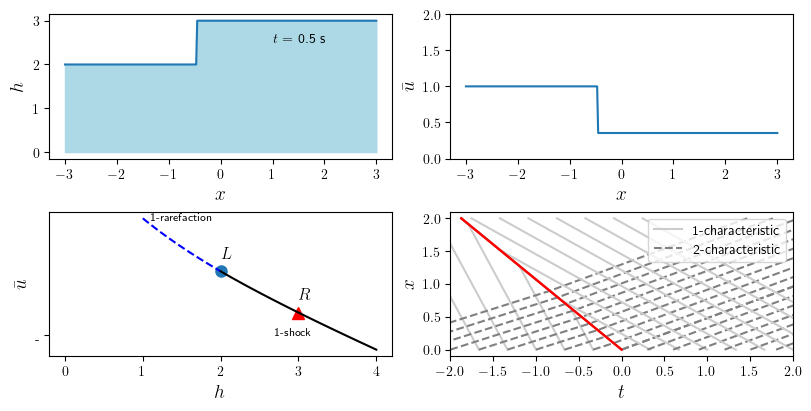

In [119]:
time = np.linspace(0.0,2,100)
s0   = sp[0]
x_0 = s0*time

fig, axs = plt.subplots(2, 2,figsize=(8,4),layout='constrained')
# depth profile
x = np.linspace(-3,3,300)
t=0.5
y = sol(x/t)[0]
axs[0,0].plot(x,y)
axs[0,0].fill_between(x, y,color='lightblue')

# velocity profile
v = sol(x/t)[1]
axs[0,1].plot(x,v)
umax = max(ul,ur)
axs[0,1].set_ylim([0,2])

# Characterist curves
interval = np.linspace(0,-3,10)
for x0 in interval:
      # 1-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 1, g = 1)
      x_c = charac_curve(time)
      axs[1,1].plot(x_c,time, color = '0.8')
      # 2-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 2, g = 1)
      x_c = charac_curve(time)
      axs[1,1].plot(x_c,time, '--', color = '0.5')

interval = np.linspace(0,3,10)
 
for x0 in interval:
      # 1-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 1, g = 1)
      x_c = charac_curve(time)
      if x0 == interval[-1]:
            axs[1,1].plot(x_c,time, color = '0.8', label="1-characteristic")
      else:
            axs[1,1].plot(x_c,time, color = '0.8')
      # 2-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 2, g = 1 )
      x_c = charac_curve(time)
      if x0 == interval[-1]:
            axs[1,1].plot(x_c,time, '--',color ='0.5', label="2-characteristic")
      else:
            axs[1,1].plot(x_c,time, '--',color ='0.5' )
axs[1,1].set_xlim([-2,2])

# phase plane
axs[1,0].plot(hl,ul,'o', markersize=8)
axs[1,0].plot(hr,ur,'^r', markersize=8)
x = np.linspace(1,hl,100)
y = list(map(phi_l,x))
x2 = np.linspace(hl,4,100)
y2 = list(map(phi_l,x2))

axs[1,0].plot(x,y,'--',color='b')
axs[1,0].plot(x2,y2,'k', '-')
axs[1,0].text(hl,ul+0.2,r'$L$',fontsize=12)
axs[1,0].text(hr,ur+0.2,r'$R$',fontsize=12)
axs[1,0].text(1.1,1.8,r'1-rarefaction',fontsize=8)
axs[1,0].text(2.7,0.0,r'1-shock',fontsize=8)

#y and x labels
axs[0,0].set_ylabel(r'$h$',fontsize=14)
axs[0,1].set_ylabel(r'$\bar u$',fontsize=14)
axs[1,0].set_ylabel(r'$\bar u$',fontsize=14)
axs[1,1].set_ylabel(r'$x$',fontsize=14)

axs[0,0].set_xlabel(r'$x$',fontsize=14)
axs[0,1].set_xlabel(r'$x$',fontsize=14)
axs[1,0].set_xlabel(r'$h$',fontsize=14)
axs[1,1].set_xlabel(r'$t$',fontsize=14)

axs[1,1].plot(x_0,time,'r')

axs[1,1].legend(loc='upper right')

axs[1,1].plot(x_0,time,'r')

# add caption
axs[1,1].legend(loc='upper right')

#time label
axs[0,0].text(1,2.5,r'$t$ = {:.1f} s'.format(t))

plt.show()
fig.savefig('1-shock.pdf', bbox_inches='tight')


## 2-shock

In [100]:
# 2-shock
hl = 3

hr = 2
ur = 1
ul = phi_r(hl)
 
print(ul)


type, st, sol, sp, hm, um = exact_solver((hl,ul),(hr,ur),g=1)
print((hm, um))
print(type)
print(st)
print(sp)


1.6454972243679027
(0, 0)
2-shock
['contact', 'shock']
[2.93649167 0.         0.         0.         0.        ]


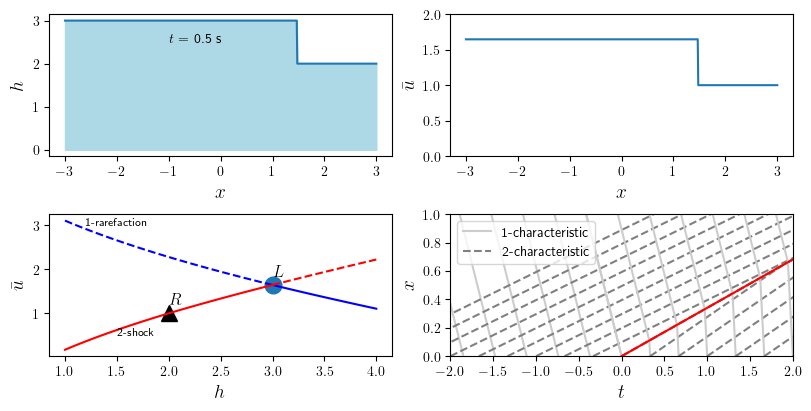

In [103]:
time = np.linspace(0.0,2,100)

s0   = sp[0]
x_0 = s0*time

fig, axs = plt.subplots(2, 2,figsize=(8,4) ,layout='constrained')
# depth profile
x = np.linspace(-3,3,600)
t=0.5
y = sol(x/t)[0]
axs[0,0].plot(x,y)
axs[0,0].fill_between(x, y,color='lightblue')

# velocity profile
v = sol(x/t)[1]
axs[0,1].plot(x,v)
umax = max(ul,ur)
axs[0,1].set_ylim([0,2])

# Characterist curves
axs[1,1].set_xlim([-2,2])
axs[1,1].set_ylim([0,1])
interval = np.linspace(-0,-3,10)
for x0 in interval:
      # 1-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 1, g = 1)
      x_c = charac_curve(time)
      axs[1,1].plot(x_c,time, color = '0.8')
      # 2-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 2, g = 1)
      x_c = charac_curve(time)
      axs[1,1].plot(x_c,time, '--', color = '0.5')

interval = np.linspace(0,3,10)
 
for x0 in interval:
      # 1-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 1, g = 1)
      x_c = charac_curve(time)
      if x0 == interval[-1]:
            axs[1,1].plot(x_c,time, color = '0.8', label="1-characteristic")
      else:
            axs[1,1].plot(x_c,time, color = '0.8')
      # 2-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 2, g = 1 )
      x_c = charac_curve(time)
      if x0 == interval[-1]:
            axs[1,1].plot(x_c,time, '--',color ='0.5', label="2-characteristic")
      else:
            axs[1,1].plot(x_c,time, '--',color ='0.5' )

# phase plane
axs[1,0].plot(hl,ul,'o', markersize=8)
axs[1,0].plot(hr,ur,'^k', markersize=8)
x = np.linspace(1,hl,100)
y1l = list(map(phi_l,x))
y2l = list(map(phi_r,x))
x2 = np.linspace(hl,4,100)
y1r = list(map(phi_l,x2))
y2r = list(map(phi_r,x2))

axs[1,0].plot(x,y1l,'--',color='b')
axs[1,0].plot(x2,y1r,'b')

axs[1,0].plot(x,y2l,color='r')
axs[1,0].plot(x2,y2r,'--',color='r')

axs[1,0].text(hl,ul+0.2,r'$L$',fontsize=12)
axs[1,0].text(hr,ur+0.2,r'$R$',fontsize=12)

axs[1,0].text(1.2,3,r'1-rarefaction',fontsize=8)
axs[1,0].text(1.5,0.5,r'2-shock',fontsize=8)


#y and x labels
axs[0,0].set_ylabel(r'$h$',fontsize=14)
axs[0,1].set_ylabel(r'$\bar u$',fontsize=14)
axs[1,0].set_ylabel(r'$\bar u$',fontsize=14)
axs[1,1].set_ylabel(r'$x$',fontsize=14)

axs[0,0].set_xlabel(r'$x$',fontsize=14)
axs[0,1].set_xlabel(r'$x$',fontsize=14)
axs[1,0].set_xlabel(r'$h$',fontsize=14)
axs[1,1].set_xlabel(r'$t$',fontsize=14)

axs[1,1].plot(x_0,time,'r')

# add caption
axs[1,1].legend(loc='upper left')

#time label
axs[0,0].text(-1,2.5,r'$t$ = {:.1f} s'.format(t))
plt.show()
fig.savefig('2-shock.pdf', bbox_inches='tight')

## 1-rarefaction

In [120]:
# 1-rarefaction
hl = 3
ul = 1
hr = 2
ur = phi_l(hr)
#exact_solver((hl,ul),(hr,ur),g=1)
print(ur)


type, st, sol, sp, hm, um = exact_solver((hl,ul),(hr,ur),g=1)
print((hm, um))
print(type)
print(st)
print(sp)

 

1.635674490391564
(0, 0)
1-rarefaction
['rarefaction', 'contact']
[-0.73205081  0.22146093  0.          0.          0.        ]


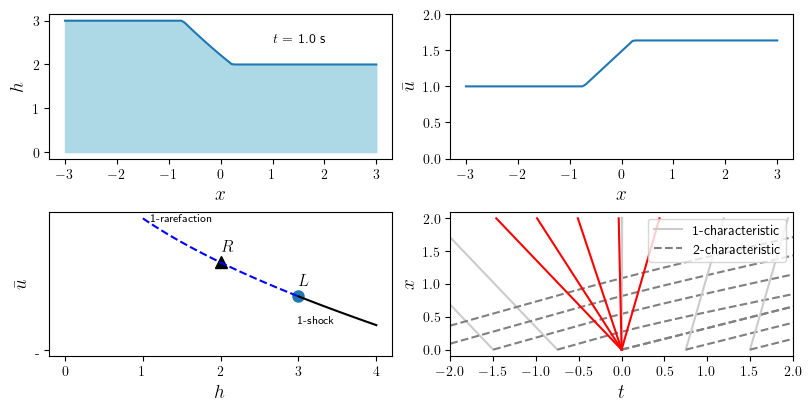

In [121]:
time = np.linspace(0.0,2,100)

s0   = sp[0]
s1   = sp[1]
x_0  = s0*time
x_1  = s1*time

x_a = (0.75*s0+ 0.25*s1)*time
x_b = (0.25*s0+ 0.75*s1)*time
x_d = (0.50*s0+ 0.50*s1)*time

fig, axs = plt.subplots(2, 2,figsize=(8,4) ,layout='constrained')
# depth profile
x = np.linspace(-3,3,100)
t=1
y = sol(x/t)[0]
axs[0,0].plot(x,y)
axs[0,0].fill_between(x, y,color='lightblue')

# velocity profile
v = sol(x/t)[1]
axs[0,1].plot(x,v)
umax = max(ul,ur)
axs[0,1].set_ylim([0,2])

# Characterist curves
interval = np.linspace(-0,-3,5)
axs[1,1].set_xlim([-2,2])
for x0 in interval:
      # 1-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 1, g = 1)
      x_c = charac_curve(time)
      axs[1,1].plot(x_c,time, color = '0.8')
      # 2-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 2, g = 1)
      x_c = charac_curve(time)
      axs[1,1].plot(x_c,time, '--', color = '0.5')

interval = np.linspace(0,3,5)
 
for x0 in interval:
      # 1-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 1, g = 1)
      x_c = charac_curve(time)
      if x0 == interval[-1]:
            axs[1,1].plot(x_c,time, color = '0.8', label="1-characteristic")
      else:
            axs[1,1].plot(x_c,time, color = '0.8')
      # 2-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 2, g = 1 )
      x_c = charac_curve(time)
      if x0 == interval[-1]:
            axs[1,1].plot(x_c,time, '--',color ='0.5', label="2-characteristic")
      else:
            axs[1,1].plot(x_c,time, '--',color ='0.5' )

# phase plane
axs[1,0].plot(hl,ul,'o', markersize=8)
axs[1,0].plot(hr,ur,'^k', markersize=8)
x = np.linspace(1,hl,100)
y = list(map(phi_l,x))
x2 = np.linspace(hl,4,100)
y2 = list(map(phi_l,x2))

axs[1,0].plot(x,y,'--',color='b')
axs[1,0].plot(x2,y2,'k', '-')
axs[1,0].text(hl,ul+0.2,r'$L$',fontsize=12)
axs[1,0].text(hr,ur+0.2,r'$R$',fontsize=12)
axs[1,0].text(1.1,2.4,r'1-rarefaction',fontsize=8)
axs[1,0].text(3,0.5,r'1-shock',fontsize=8)

#time label
axs[0,0].text(1,2.5,r'$t$ = {:.1f} s'.format(t))

#y and x labels
axs[0,0].set_ylabel(r'$h$',fontsize=14)
axs[0,1].set_ylabel(r'$\bar u$',fontsize=14)
axs[1,0].set_ylabel(r'$\bar u$',fontsize=14)
axs[1,1].set_ylabel(r'$x$',fontsize=14)

axs[0,0].set_xlabel(r'$x$',fontsize=14)
axs[0,1].set_xlabel(r'$x$',fontsize=14)
axs[1,0].set_xlabel(r'$h$',fontsize=14)
axs[1,1].set_xlabel(r'$t$',fontsize=14)

axs[1,1].legend(loc='upper right')

axs[1,1].plot(x_0,time,'r')
axs[1,1].plot(x_1,time,'r')
axs[1,1].plot(x_a,time,'r')
axs[1,1].plot(x_b,time,'r')
axs[1,1].plot(x_d,time,'r')

 
plt.show()
fig.savefig('1-rarefaction.pdf', bbox_inches='tight')
 

## 2-rarefaction

In [80]:
# 2-rarefaction
hl = 2
ur = 1
hr = 3
ul = phi_r(hl)

print(ul)


type, st, sol, sp, hm, um = exact_solver((hl,ul),(hr,ur),g=1)
print((hm, um))
print(type)
print(st)
print(sp)

0.3643255096084359
(0, 0)
2-rarefaction
['contact', 'rarefaction']
[1.77853907 2.73205081 0.         0.         0.        ]


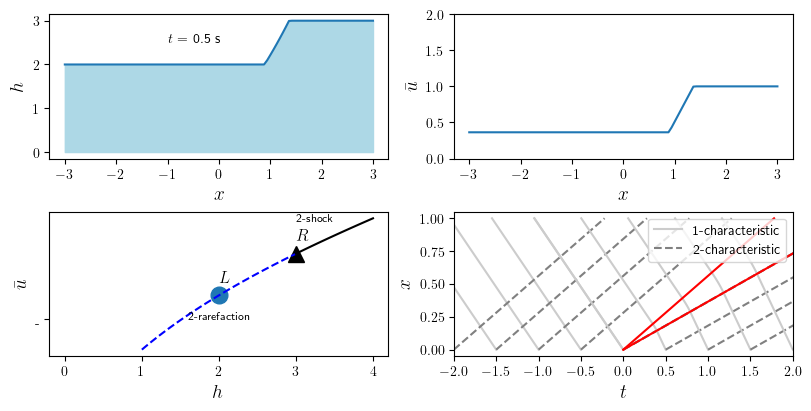

In [126]:
time = np.linspace(0.0,1,100)

s0   = sp[0]
s1   = sp[1]
x_0  = s0*time
x_1  = s1*time

fig, axs = plt.subplots(2, 2,figsize=(8,4) ,layout='constrained')
# depth profile
x = np.linspace(-3,3,100)
t=0.5
y = sol(x/t)[0]
axs[0,0].plot(x,y)
axs[0,0].fill_between(x, y,color='lightblue')

# velocity profile
v = sol(x/t)[1]
axs[0,1].plot(x,v)
umax = max(ul,ur)
axs[0,1].set_ylim([0,2])

# Characterist curves
interval = np.linspace(-0,-2,5)
axs[1,1].set_xlim([-2,2])
for x0 in interval:
      # 1-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 1, g = 1)
      x_c = charac_curve(time)
      axs[1,1].plot(x_c,time, color = '0.8')
      # 2-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 2, g = 1)
      x_c = charac_curve(time)
      axs[1,1].plot(x_c,time, '--', color = '0.5')

interval = np.linspace(0,2,5)
 
for x0 in interval:
      # 1-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 1, g = 1)
      x_c = charac_curve(time)
      if x0 == interval[-1]:
            axs[1,1].plot(x_c,time, color = '0.8', label="1-characteristic")
      else:
            axs[1,1].plot(x_c,time, color = '0.8')
      # 2-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 2, g = 1 )
      x_c = charac_curve(time)
      if x0 == interval[-1]:
            axs[1,1].plot(x_c,time, '--',color ='0.5', label="2-characteristic")
      else:
            axs[1,1].plot(x_c,time, '--',color ='0.5' )

# phase plane
axs[1,0].plot(hl,ul,'o', markersize=8)
axs[1,0].plot(hr,ur,'^k', markersize=8)
x = np.linspace(1,hr,100)
y = list(map(phi_r,x))
x2 = np.linspace(hr,4,100)
y2 = list(map(phi_r,x2))

axs[1,0].plot(x,y,'--',color='b')
axs[1,0].plot(x2,y2,'k', '-')
axs[1,0].text(hl,ul+0.2,r'$L$',fontsize=12)
axs[1,0].text(hr,ur+0.2,r'$R$',fontsize=12)
axs[1,0].text(1.6,0.0,r'2-rarefaction',fontsize=8)
axs[1,0].text(3,1.5,r'2-shock',fontsize=8)

#time label
axs[0,0].text(-1,2.5,r'$t$ = {:.1f} s'.format(t))

#y and x labels
axs[0,0].set_ylabel(r'$h$',fontsize=14)
axs[0,1].set_ylabel(r'$\bar u$',fontsize=14)
axs[1,0].set_ylabel(r'$\bar u$',fontsize=14)
axs[1,1].set_ylabel(r'$x$',fontsize=14)

axs[0,0].set_xlabel(r'$x$',fontsize=14)
axs[0,1].set_xlabel(r'$x$',fontsize=14)
axs[1,0].set_xlabel(r'$h$',fontsize=14)
axs[1,1].set_xlabel(r'$t$',fontsize=14)

axs[1,1].legend(loc='upper right')

axs[1,1].plot(x_0,time,'r')
axs[1,1].plot(x_1,time,'r')
 
plt.show()
fig.savefig('2-rarefaction.pdf', bbox_inches='tight')

## Wet bed: 1-rarefaction + 2-shock

In [88]:
# Wet bed
hl = 2
ul = 0
hr = 1
ur = 0
 
print(ul)

type, st, sol, sp, hm, um = exact_solver((hl,ul),(hr,ur),g=1)
print((hm, um))
print(type)
print(st)
print(sp)

0
(1.4538408923745731, 0.4169206309754828)
wet
['rarefaction', 'shock']
[-1.41421356 -0.78883262  1.33556996  0.          0.        ]


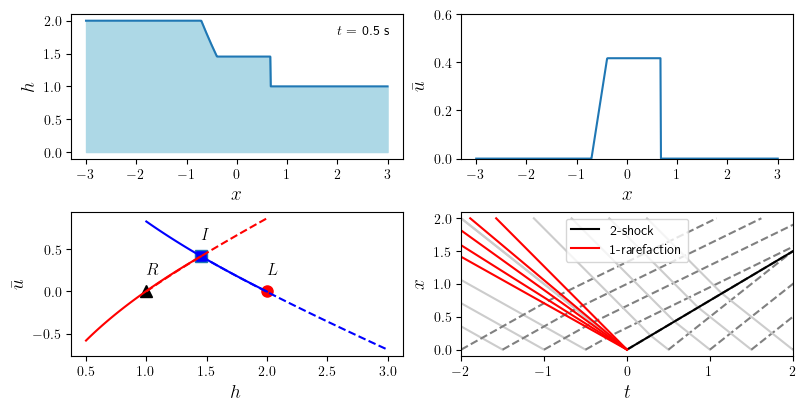

In [90]:

time = np.linspace(0.0,2,100)

s0   = sp[0]
s1   = sp[1]
s2   = sp[2]
x_0  = s0*time
x_1  = s1*time
x_2  = s2*time
x_a = (0.75*s0+ 0.25*s1)*time
x_b = (0.25*s0+ 0.75*s1)*time
x_d = (0.50*s0+ 0.50*s1)*time

fig, axs = plt.subplots(2, 2,figsize=(8,4) ,layout='constrained')
# depth profile
x = np.linspace(-3,3,600)
t=0.5
y = sol(x/t)[0]
axs[0,0].plot(x,y)
axs[0,0].fill_between(x, y,color='lightblue')

# velocity profile
v = sol(x/t)[1]
axs[0,1].plot(x,v)
umax = max(ul,ur)
axs[0,1].set_ylim([0,0.6])

# Characterist curves
axs[1,1].set_xlim([-2,2])
interval = np.linspace(-0,-2,5)
for x0 in interval:
      # 1-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 1, g = 1)
      x_c = charac_curve(time)
      axs[1,1].plot(x_c,time, color = '0.8')
      # 2-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 2, g = 1)
      x_c = charac_curve(time)
      axs[1,1].plot(x_c,time, '--', color = '0.5')

interval = np.linspace(0,2,5)
 
for x0 in interval:
      # 1-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 1, g = 1)
      x_c = charac_curve(time)
      if x0 == interval[-1]:
            axs[1,1].plot(x_c,time, color = '0.8')
      else:
            axs[1,1].plot(x_c,time, color = '0.8')
      # 2-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 2, g = 1 )
      x_c = charac_curve(time)
      if x0 == interval[-1]:
            axs[1,1].plot(x_c,time, '--',color ='0.5')
      else:
            axs[1,1].plot(x_c,time, '--',color ='0.5' )

# phase plane
axs[1,0].plot(hl,ul,'or', markersize=8)
axs[1,0].plot(hr,ur,'^k', markersize=8)
axs[1,0].plot(hm,um,marker = 's', markersize=8, markerfacecolor='blue')
x = np.linspace(1,hl,100)
y1l = list(map(phi_l,x))
y2l = list(map(phi_r,x))

x2 = np.linspace(hm,3,100)
y1m = list(map(phi_lm,x2))
x3 = np.linspace(0.5,hm,100)
y2m = list(map(phi_rm,x3))

axs[1,0].plot(x,y1l,color='b')
axs[1,0].plot(x2,y1m,'--',color = 'b')

axs[1,0].plot(x,y2l,'--',color='r')
axs[1,0].plot(x3,y2m,color='r')

axs[1,0].text(hl,ul+0.2,r'$L$',fontsize=12)
axs[1,0].text(hr,ur+0.2,r'$R$',fontsize=12)
axs[1,0].text(hm,um+0.2,r'$I$',fontsize=12)

#axs[1,0].text(1.2,3,r'1-rarefaction',fontsize=8)
#axs[1,0].text(1.5,0.5,r'2-shock',fontsize=8)

#time label
axs[0,0].text(2,1.8,r'$t$ = {:.1f} s'.format(t))

#y and x labels
axs[0,0].set_ylabel(r'$h$',fontsize=14)
axs[0,1].set_ylabel(r'$\bar u$',fontsize=14)
axs[1,0].set_ylabel(r'$\bar u$',fontsize=14)
axs[1,1].set_ylabel(r'$x$',fontsize=14)

axs[0,0].set_xlabel(r'$x$',fontsize=14)
axs[0,1].set_xlabel(r'$x$',fontsize=14)
axs[1,0].set_xlabel(r'$h$',fontsize=14)
axs[1,1].set_xlabel(r'$t$',fontsize=14)

#axs[1,1].legend(loc='upper right')

axs[1,1].plot(x_0,time,'r')
axs[1,1].plot(x_1,time,'r')
axs[1,1].plot(x_2,time,'k',label='2-shock')
axs[1,1].plot(x_a,time,'r')
axs[1,1].plot(x_b,time,'r')
axs[1,1].plot(x_d,time,'r',label = '1-rarefaction')
axs[1,1].legend(loc='upper center')
 
plt.show()
fig.savefig('1rarefaction-2shock.pdf', bbox_inches='tight')

## Wet bed: 1-shock + 2-rarefaction

In [69]:
# Wet bed
hl = 1
ul = 0
hr = 2
ur = 0

type, st, sol, sp, hm, um = exact_solver((hl,ul),(hr,ur),g=1)
print((hm, um))
print(type)
print(st)
print(sp)

(1.4538408923745731, -0.4169206309754828)
wet
['shock', 'rarefaction']
[-1.33556996  0.78883262  1.41421356  0.          0.        ]


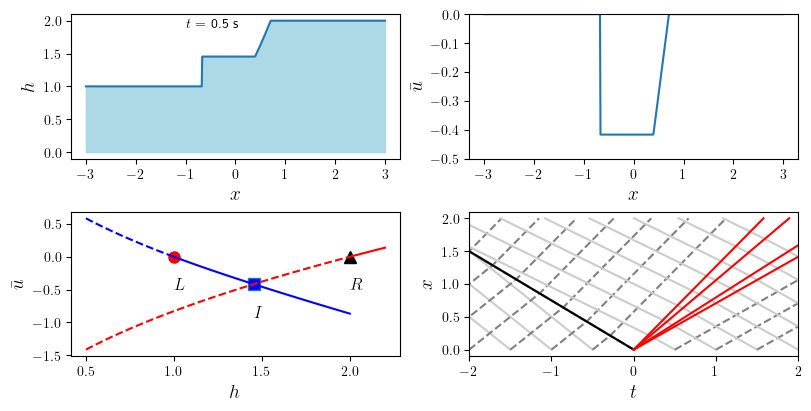

In [76]:
time = np.linspace(0.0,2,100)

s0   = sp[0]
s1   = sp[1]
s2   = sp[2]
x_0  = s0*time
x_1  = s1*time
x_2  = s2*time
x_a = (0.75*s2+ 0.25*s1)*time
x_b = (0.25*s2+ 0.75*s1)*time

fig, axs = plt.subplots(2, 2,figsize=(8,4) ,layout='constrained')
# depth profile
x = np.linspace(-3,3,600)
t = 0.5
y = sol(x/t)[0]
axs[0,0].plot(x,y)
axs[0,0].fill_between(x, y,color='lightblue')

# velocity profile
v = sol(x/t)[1]
axs[0,1].plot(x,v)
umax = max(ul,ur)
axs[0,1].set_ylim([-.5,0])

# Characterist curves
interval = np.linspace(-0,-4,9)
axs[1,1].set_xlim([-2,2])
for x0 in interval:
      # 1-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 1, g = 1)
      x_c = charac_curve(time)
      axs[1,1].plot(x_c,time, color = '0.8')
      # 2-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 2, g = 1)
      x_c = charac_curve(time)
      axs[1,1].plot(x_c,time, '--', color = '0.5')

interval = np.linspace(0,4,9)
 
for x0 in interval:
      # 1-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 1, g = 1)
      x_c = charac_curve(time)
      if x0 == interval[-1]:
            axs[1,1].plot(x_c,time, color = '0.8', label="1-characteristic")
      else:
            axs[1,1].plot(x_c,time, color = '0.8')
      # 2-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 2, g = 1 )
      x_c = charac_curve(time)
      if x0 == interval[-1]:
            axs[1,1].plot(x_c,time, '--',color ='0.5', label="2-characteristic")
      else:
            axs[1,1].plot(x_c,time, '--',color ='0.5' )

# phase plane
axs[1,0].plot(hl,ul,'or', markersize=8)
axs[1,0].plot(hr,ur,'^k', markersize=8)
axs[1,0].plot(hm,um,marker = 's', markersize=8, markerfacecolor='blue')


 
x   = np.linspace(hl,2,100)
y1l = list(map(phi_l,x))
axs[1,0].plot(x,y1l,color='b')

x1  = np.linspace(0.5,hl,100)
y2l = list(map(phi_l,x1))
axs[1,0].plot(x1,y2l,'--',color = 'b')

x2 = np.linspace(hr,2.2,100)
y1r = list(map(phi_r,x2))
axs[1,0].plot(x2,y1r, color='r')


x3 = np.linspace(0.5,hr,100)
y2r = list(map(phi_r,x3))
axs[1,0].plot(x3,y2r,'--',color='r')


axs[1,0].text(hl,ul-0.5,r'$L$',fontsize=12)
axs[1,0].text(hr,ur-0.5,r'$R$',fontsize=12)
axs[1,0].text(hm,um-0.5,r'$I$',fontsize=12)

#axs[1,0].text(1.2,3,r'1-rarefaction',fontsize=8)
#axs[1,0].text(1.5,0.5,r'2-shock',fontsize=8)

#time label
axs[0,0].text(-1,1.9,r'$t$ = {:.1f} s'.format(t))

#y and x labels
axs[0,0].set_ylabel(r'$h$',fontsize=14)
axs[0,1].set_ylabel(r'$\bar u$',fontsize=14)
axs[1,0].set_ylabel(r'$\bar u$',fontsize=14)
axs[1,1].set_ylabel(r'$x$',fontsize=14)

axs[0,0].set_xlabel(r'$x$',fontsize=14)
axs[0,1].set_xlabel(r'$x$',fontsize=14)
axs[1,0].set_xlabel(r'$h$',fontsize=14)
axs[1,1].set_xlabel(r'$t$',fontsize=14)

#axs[1,1].legend(loc='upper right')

axs[1,1].plot(x_0,time,'k')
axs[1,1].plot(x_1,time,'r')
axs[1,1].plot(x_2,time,'r')
axs[1,1].plot(x_a,time,'r')
axs[1,1].plot(x_b,time,'r')

plt.show()
fig.savefig('1shock-2rarefaction.pdf', bbox_inches='tight')

## wet bed: 2 shock waves

In [110]:
# Wet bed
hl = 1
ul = 2
hr = 1
ur = 1

type, st, sol, sp, hm, um = exact_solver((hl,ul),(hr,ur),g=1)
print((hm, um))
print(type)
print(st)
print(sp)

(1.5513875245483204, 1.5)
wet
['shock', 'shock']
[0.59319675 2.40680325 0.         0.         0.        ]


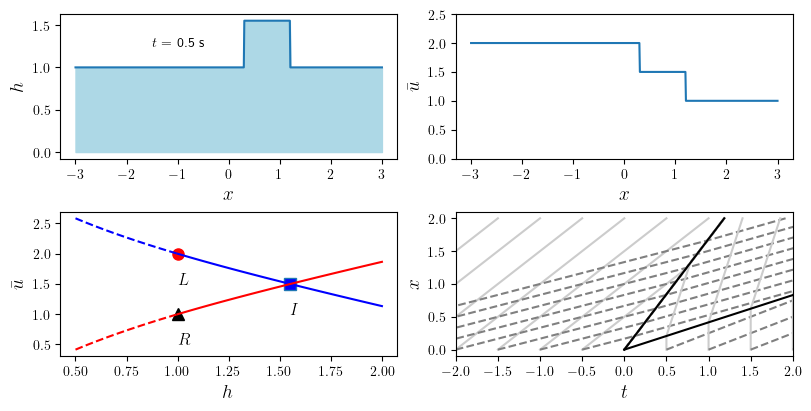

In [113]:
time = np.linspace(0.0,2,100)

s0   = sp[0]
s1   = sp[1]

x_0  = s0*time
x_1  = s1*time

fig, axs = plt.subplots(2, 2,figsize=(8,4) ,layout='constrained')
# depth profile
x = np.linspace(-3,3,600)
t = 0.5
y = sol(x/t)[0]
axs[0,0].plot(x,y)
axs[0,0].fill_between(x, y,color='lightblue')

# velocity profile
v = sol(x/t)[1]
axs[0,1].plot(x,v)
umax = max(ul,ur)
axs[0,1].set_ylim([0,2.5])

# Characterist curves
interval = np.linspace(-0,-4,9)
axs[1,1].set_xlim([-2,2])
for x0 in interval:
      # 1-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 1, g = 1)
      x_c = charac_curve(time)
      axs[1,1].plot(x_c,time, color = '0.8')
      # 2-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 2, g = 1)
      x_c = charac_curve(time)
      axs[1,1].plot(x_c,time, '--', color = '0.5')

interval = np.linspace(0,4,9)
 
for x0 in interval:
      # 1-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 1, g = 1)
      x_c = charac_curve(time)
      if x0 == interval[-1]:
            axs[1,1].plot(x_c,time, color = '0.8', label="1-characteristic")
      else:
            axs[1,1].plot(x_c,time, color = '0.8')
      # 2-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 2, g = 1 )
      x_c = charac_curve(time)
      if x0 == interval[-1]:
            axs[1,1].plot(x_c,time, '--',color ='0.5', label="2-characteristic")
      else:
            axs[1,1].plot(x_c,time, '--',color ='0.5' )

# phase plane
axs[1,0].plot(hl,ul,'or', markersize=8)
axs[1,0].plot(hr,ur,'^k', markersize=8)
axs[1,0].plot(hm,um,marker = 's', markersize=8, markerfacecolor='blue')


 
x   = np.linspace(hl,2,100)
y1l = list(map(phi_l,x))
axs[1,0].plot(x,y1l,color='b')

x1  = np.linspace(0.5,hl,100)
y2l = list(map(phi_l,x1))
axs[1,0].plot(x1,y2l,'--',color = 'b')

x2 = np.linspace(hr,2.,100)
y1r = list(map(phi_r,x2))
axs[1,0].plot(x2,y1r, color='r')


x3 = np.linspace(0.5,hr,100)
y2r = list(map(phi_r,x3))
axs[1,0].plot(x3,y2r,'--',color='r')


axs[1,0].text(hl,ul-0.5,r'$L$',fontsize=12)
axs[1,0].text(hr,ur-0.5,r'$R$',fontsize=12)
axs[1,0].text(hm,um-0.5,r'$I$',fontsize=12)

#axs[1,0].text(1.2,3,r'1-rarefaction',fontsize=8)
#axs[1,0].text(1.5,0.5,r'2-shock',fontsize=8)

#time label
axs[0,0].text(-1.5,1.25,r'$t$ = {:.1f} s'.format(t))

#y and x labels
axs[0,0].set_ylabel(r'$h$',fontsize=14)
axs[0,1].set_ylabel(r'$\bar u$',fontsize=14)
axs[1,0].set_ylabel(r'$\bar u$',fontsize=14)
axs[1,1].set_ylabel(r'$x$',fontsize=14)

axs[0,0].set_xlabel(r'$x$',fontsize=14)
axs[0,1].set_xlabel(r'$x$',fontsize=14)
axs[1,0].set_xlabel(r'$h$',fontsize=14)
axs[1,1].set_xlabel(r'$t$',fontsize=14)

#axs[1,1].legend(loc='upper right')

axs[1,1].plot(x_0,time,'k')
axs[1,1].plot(x_1,time,'k')


plt.show()
fig.savefig('1shock-2shock.pdf', bbox_inches='tight')

## wet cavity: two rarefaction waves

In [81]:
# Wet bed
hl = 1
ul = -1
hr = 1
ur = 1

type, st, sol, sp, hm, um = exact_solver((hl,ul),(hr,ur),g=1)
print((hm, um))
print(type)
print(st)
print(sp)

-1
(0.25, 0.0)
wet
['rarefaction', 'rarefaction']
[-2.  -0.5  0.5  2.   0. ]


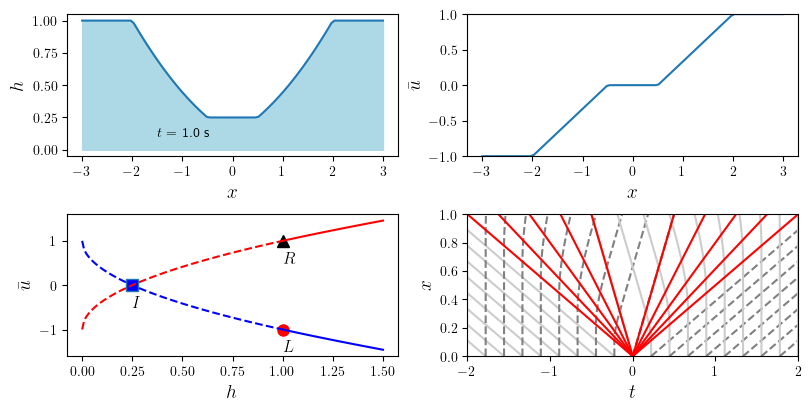

In [84]:
time = np.linspace(0.0,1,100)

s0   = sp[0]
s1   = sp[1]
s2   = sp[2]
s3   = sp[3]
x_0  = s0*time
x_1  = s1*time
x_2  = s2*time
x_3  = s3*time

x_a = (0.75*s0+ 0.25*s1)*time
x_b = (0.25*s0+ 0.75*s1)*time
x_d = (0.50*s0+ 0.50*s1)*time

x_e = (0.75*s2+ 0.25*s3)*time
x_f = (0.25*s2+ 0.75*s3)*time
x_g = (0.50*s2+ 0.50*s3)*time


fig, axs = plt.subplots(2, 2,figsize=(8,4) ,layout='constrained')
# depth profile
x = np.linspace(-3,3,100)
t = 1
y = sol(x/t)[0]
axs[0,0].plot(x,y)
axs[0,0].fill_between(x, y,color='lightblue')

# velocity profile
v = sol(x/t)[1]
axs[0,1].plot(x,v)
umax = max(ul,ur)
axs[0,1].set_ylim([-1,1])

# Characterist curves
interval = np.linspace(-0,-2,10)
axs[1,1].set_ylim([0,1])
axs[1,1].set_xlim([-2,2])
for x0 in interval:
      # 1-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 1, g = 1)
      x_c = charac_curve(time)
      axs[1,1].plot(x_c,time, color = '0.8')
      # 2-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 2, g = 1)
      x_c = charac_curve(time)
      axs[1,1].plot(x_c,time, '--', color = '0.5')

interval = np.linspace(0,2,10)
 
for x0 in interval:
      # 1-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 1, g = 1)
      x_c = charac_curve(time)
      if x0 == interval[-1]:
            axs[1,1].plot(x_c,time, color = '0.8', label="1-characteristic")
      else:
            axs[1,1].plot(x_c,time, color = '0.8')
      # 2-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 2, g = 1 )
      x_c = charac_curve(time)
      if x0 == interval[-1]:
            axs[1,1].plot(x_c,time, '--',color ='0.5', label="2-characteristic")
      else:
            axs[1,1].plot(x_c,time, '--',color ='0.5' )

# phase plane
axs[1,0].plot(hl,ul,'or', markersize=8)
axs[1,0].plot(hr,ur,'^k', markersize=8)
axs[1,0].plot(hm,um,marker = 's', markersize=8, markerfacecolor='blue')


 
x   = np.linspace(hl,1.5,100)
y1l = list(map(phi_l,x))
axs[1,0].plot(x,y1l,color='b')

x1  = np.linspace(0.0,hl,100)
y2l = list(map(phi_l,x1))
axs[1,0].plot(x1,y2l,'--',color = 'b')

x2  = np.linspace(hr,1.5,100)
y1r = list(map(phi_r,x2))
axs[1,0].plot(x2,y1r, color='r')


x3  = np.linspace(0.0,hr,100)
y2r = list(map(phi_r,x3))
axs[1,0].plot(x3,y2r,'--',color='r')


axs[1,0].text(hl,ul-0.5,r'$L$',fontsize=12)
axs[1,0].text(hr,ur-0.5,r'$R$',fontsize=12)
axs[1,0].text(hm,um-0.5,r'$I$',fontsize=12)

#axs[1,0].text(1.2,3,r'1-rarefaction',fontsize=8)
#axs[1,0].text(1.5,0.5,r'2-shock',fontsize=8)

#time label
axs[0,0].text(-1.5,0.1,r'$t$ = {:.1f} s'.format(t))

#y and x labels
axs[0,0].set_ylabel(r'$h$',fontsize=14)
axs[0,1].set_ylabel(r'$\bar u$',fontsize=14)
axs[1,0].set_ylabel(r'$\bar u$',fontsize=14)
axs[1,1].set_ylabel(r'$x$',fontsize=14)

axs[0,0].set_xlabel(r'$x$',fontsize=14)
axs[0,1].set_xlabel(r'$x$',fontsize=14)
axs[1,0].set_xlabel(r'$h$',fontsize=14)
axs[1,1].set_xlabel(r'$t$',fontsize=14)

#axs[1,1].legend(loc='upper right')

axs[1,1].plot(x_0,time,'r')
axs[1,1].plot(x_1,time,'r')
axs[1,1].plot(x_2,time,'r')
axs[1,1].plot(x_3,time,'r')

axs[1,1].plot(x_e,time,'r')
axs[1,1].plot(x_f,time,'r')
axs[1,1].plot(x_g,time,'r')
axs[1,1].plot(x_a,time,'r')
axs[1,1].plot(x_b,time,'r')
axs[1,1].plot(x_d,time,'r')

plt.show()
fig.savefig('1rarefaction-2rarefaction.pdf', bbox_inches='tight')

## dry cavity: two rarefaction waves

In [114]:
# dry cavity
hl = 1
ul = -3
hr = 1
ur = 3
 
print(ul)


type, st, sol, sp, hm, um = exact_solver((hl,ul),(hr,ur),g=1)
print((hm, um))
print(type)
print(st)
print(sp)

-3
(0, 0)
dry-cavity
['rarefaction', 'rarefaction']
[-4. -1.  1.  4.  0.]


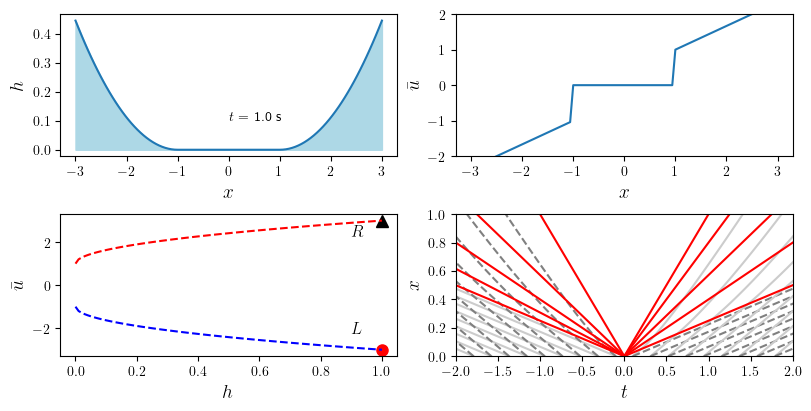

In [117]:
time = np.linspace(0.0,1,100)

s0   = sp[0]
s1   = sp[1]
s2   = sp[2]
s3   = sp[3]
x_0  = s0*time
x_1  = s1*time
x_2  = s2*time
x_3  = s3*time

x_a = (0.75*s0+ 0.25*s1)*time
x_b = (0.25*s0+ 0.75*s1)*time
x_d = (0.50*s0+ 0.50*s1)*time

x_e = (0.75*s2+ 0.25*s3)*time
x_f = (0.25*s2+ 0.75*s3)*time
x_f = (0.50*s2+ 0.50*s3)*time

fig, axs = plt.subplots(2, 2,figsize=(8,4) ,layout='constrained')
# depth profile
x = np.linspace(-3,3,100)
t = 1
y = sol(x/t)[0]
axs[0,0].plot(x,y)
axs[0,0].fill_between(x, y,color='lightblue')

# velocity profile
v = sol(x/t)[1]
axs[0,1].plot(x,v)
umax = max(ul,ur)
axs[0,1].set_ylim([-2,2])

# Characterist curves
interval = np.linspace(-0.1,-2,10)
axs[1,1].set_ylim([0,1])
axs[1,1].set_xlim([-2,2])
for x0 in interval:
      # 1-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 1, g = 1)
      x_c = charac_curve(time)
      axs[1,1].plot(x_c,time, color = '0.8')
      # 2-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 2, g = 1)
      x_c = charac_curve(time)
      axs[1,1].plot(x_c,time, '--', color = '0.5')

interval = np.linspace(0.1,2,10)
 
for x0 in interval:
      # 1-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 1, g = 1)
      x_c = charac_curve(time)
      if x0 == interval[-1]:
            axs[1,1].plot(x_c,time, color = '0.8', label="1-characteristic")
      else:
            axs[1,1].plot(x_c,time, color = '0.8')
      # 2-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 2, g = 1 )
      x_c = charac_curve(time)
      if x0 == interval[-1]:
            axs[1,1].plot(x_c,time, '--',color ='0.5', label="2-characteristic")
      else:
            axs[1,1].plot(x_c,time, '--',color ='0.5' )

# phase plane
axs[1,0].plot(hl,ul,'or', markersize=8)
axs[1,0].plot(hr,ur,'^k', markersize=8)


x1  = np.linspace(0.0,hl,100)
y2l = list(map(phi_l,x1))
axs[1,0].plot(x1,y2l,'--',color = 'b')

 
x3  = np.linspace(0.0,hr,100)
y2r = list(map(phi_r,x3))
axs[1,0].plot(x3,y2r,'--',color='r')


axs[1,0].text(hl-.1,ul+0.75,r'$L$',fontsize=12)
axs[1,0].text(hr-.1,ur-0.75,r'$R$',fontsize=12)


#axs[1,0].text(1.2,3,r'1-rarefaction',fontsize=8)
#axs[1,0].text(1.5,0.5,r'2-shock',fontsize=8)

#time label
axs[0,0].text(0,0.1,r'$t$ = {:.1f} s'.format(t))

#y and x labels
axs[0,0].set_ylabel(r'$h$',fontsize=14)
axs[0,1].set_ylabel(r'$\bar u$',fontsize=14)
axs[1,0].set_ylabel(r'$\bar u$',fontsize=14)
axs[1,1].set_ylabel(r'$x$',fontsize=14)

axs[0,0].set_xlabel(r'$x$',fontsize=14)
axs[0,1].set_xlabel(r'$x$',fontsize=14)
axs[1,0].set_xlabel(r'$h$',fontsize=14)
axs[1,1].set_xlabel(r'$t$',fontsize=14)

#axs[1,1].legend(loc='upper right')

axs[1,1].plot(x_0,time,'r')
axs[1,1].plot(x_1,time,'r')
axs[1,1].plot(x_2,time,'r')
axs[1,1].plot(x_3,time,'r')

axs[1,1].plot(x_a,time,'r')
axs[1,1].plot(x_b,time,'r')
axs[1,1].plot(x_d,time,'r')
axs[1,1].plot(x_e,time,'r')
axs[1,1].plot(x_f,time,'r')
axs[1,1].plot(x_g,time,'r')

fig.savefig('dry-cavity.pdf', bbox_inches='tight')
plt.show()

## Dry initial state: right

In [9]:
hl = 1
ul = 0
hr = 0
ur = 0
 
print(ul)


type, st, sol, sp, hm, um = exact_solver((hl,ul),(hr,ur),g=1)
print((hm, um))
print(type)
print(st)
print(sp)

0
(0, 0)
dry-right
['rarefaction', 'contact']
[-1.  2.  0.  0.  0.]


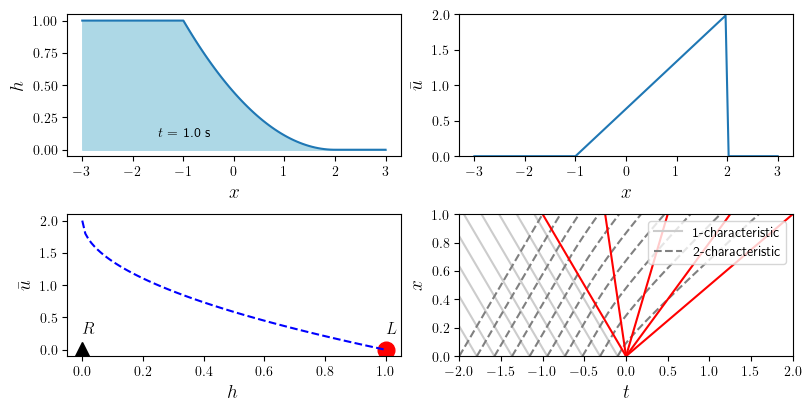

In [21]:
time = np.linspace(0.0,1,100)

s0   = sp[0]
s1   = sp[1]

x_0  = s0*time
x_1  = s1*time

x_a = (0.75*s0+ 0.25*s1)*time
x_b = (0.25*s0+ 0.75*s1)*time
x_d = (0.50*s0+ 0.50*s1)*time

fig, axs = plt.subplots(2, 2,figsize=(8,4) ,layout='constrained')
# depth profile
x = np.linspace(-3,3,100)
t = 1
y = sol(x/t)[0]
axs[0,0].plot(x,y)
axs[0,0].fill_between(x, y,color='lightblue')

# velocity profile
v = sol(x/t)[1]
axs[0,1].plot(x,v)
umax = max(ul,ur)
axs[0,1].set_ylim([0,2])

# Characterist curves
interval = np.linspace(-0.1,-2,10)
axs[1,1].set_ylim([0,1])
axs[1,1].set_xlim([-2,2])
for x0 in interval:
      # 1-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 1, g = 1)
      x_c = charac_curve(time)
      if x0 == interval[-1]:
            axs[1,1].plot(x_c,time, color = '0.8', label="1-characteristic")
      else:
            axs[1,1].plot(x_c,time, color = '0.8')
      # 2-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 2, g = 1 )
      x_c = charac_curve(time)
      if x0 == interval[-1]:
            axs[1,1].plot(x_c,time, '--',color ='0.5', label="2-characteristic")
      else:
            axs[1,1].plot(x_c,time, '--',color ='0.5' )



# phase plane
axs[1,0].plot(hl,ul,'or', markersize=8)
axs[1,0].plot(hr,ur,'^k', markersize=8)


x1  = np.linspace(0.0,hl,100)
y2l = list(map(phi_l,x1))
axs[1,0].plot(x1,y2l,'--',color = 'b')

 
x3  = np.linspace(0.0,hr,100)
y2r = list(map(phi_r,x3))
axs[1,0].plot(x3,y2r,'--',color='r')


axs[1,0].text(hl,ul+0.25,r'$L$',fontsize=12)
axs[1,0].text(hr,ur+0.25,r'$R$',fontsize=12)


#axs[1,0].text(1.2,3,r'1-rarefaction',fontsize=8)
#axs[1,0].text(1.5,0.5,r'2-shock',fontsize=8)

#time label
axs[0,0].text(-1.5,0.1,r'$t$ = {:.1f} s'.format(t))

#y and x labels
axs[0,0].set_ylabel(r'$h$',fontsize=14)
axs[0,1].set_ylabel(r'$\bar u$',fontsize=14)
axs[1,0].set_ylabel(r'$\bar u$',fontsize=14)
axs[1,1].set_ylabel(r'$x$',fontsize=14)

axs[0,0].set_xlabel(r'$x$',fontsize=14)
axs[0,1].set_xlabel(r'$x$',fontsize=14)
axs[1,0].set_xlabel(r'$h$',fontsize=14)
axs[1,1].set_xlabel(r'$t$',fontsize=14)

axs[1,1].legend(loc='upper right')

axs[1,1].plot(x_0,time,'r')
axs[1,1].plot(x_1,time,'r')
axs[1,1].plot(x_a,time,'r')
axs[1,1].plot(x_b,time,'r')
axs[1,1].plot(x_d,time,'r')

plt.show()
fig.savefig('right-dry.pdf', bbox_inches='tight')

## dry initial bed: left

In [22]:
hl = 0
ul = 0
hr = 1
ur = 0
 
print(ul)


type, st, sol, sp, hm, um = exact_solver((hl,ul),(hr,ur),g=1)
print((hm, um))
print(type)
print(st)
print(sp)

0
(0, 0)
dry-left
['contact', 'rarefaction']
[-2.  1.  0.  0.  0.]


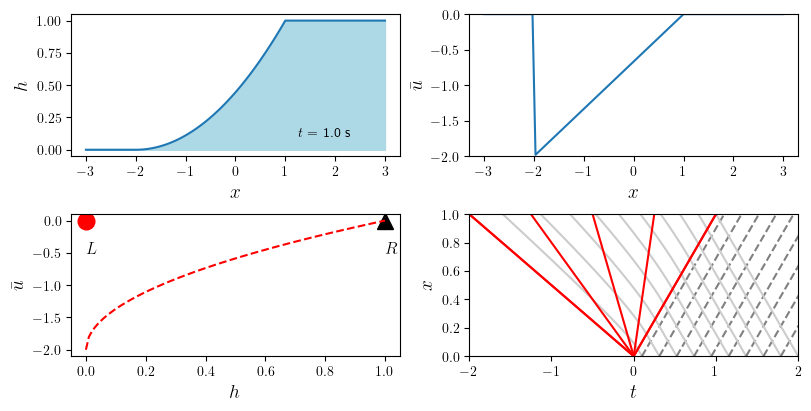

In [24]:
time = np.linspace(0.0,1,100)

s0   = sp[0]
s1   = sp[1]

x_0  = s0*time
x_1  = s1*time
x_a = (0.75*s0+ 0.25*s1)*time
x_b = (0.25*s0+ 0.75*s1)*time
x_d = (0.50*s0+ 0.50*s1)*time

fig, axs = plt.subplots(2, 2,figsize=(8,4) ,layout='constrained')
# depth profile
x = np.linspace(-3,3,100)
t = 1
y = sol(x/t)[0]
axs[0,0].plot(x,y)
axs[0,0].fill_between(x, y,color='lightblue')

# velocity profile
v = sol(x/t)[1]
axs[0,1].plot(x,v)
umax = max(ul,ur)
axs[0,1].set_ylim([-2,0])

# Characterist curves
interval = np.linspace(0.1,2,10)
axs[1,1].set_ylim([0,1])
axs[1,1].set_xlim([-2,2])
for x0 in interval:
      # 1-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 1, g = 1)
      x_c = charac_curve(time)
      axs[1,1].plot(x_c,time, color = '0.8')
      # 2-characteristic
      charac_curve = characteristic(x0, (hl,ul),(hr,ur), order = 2, g = 1)
      x_c = charac_curve(time)
      axs[1,1].plot(x_c,time, '--', color = '0.5')

# phase plane
axs[1,0].plot(hl,ul,'or', markersize=8)
axs[1,0].plot(hr,ur,'^k', markersize=8)


x1  = np.linspace(0.0,hl,100)
y2l = list(map(phi_l,x1))
axs[1,0].plot(x1,y2l,'--',color = 'b')

 
x3  = np.linspace(0.0,hr,100)
y2r = list(map(phi_r,x3))
axs[1,0].plot(x3,y2r,'--',color='r')


axs[1,0].text(hl,ul-0.5,r'$L$',fontsize=12)
axs[1,0].text(hr,ur-0.5,r'$R$',fontsize=12)


#axs[1,0].text(1.2,3,r'1-rarefaction',fontsize=8)
#axs[1,0].text(1.5,0.5,r'2-shock',fontsize=8)

#time label
axs[0,0].text(1.25,0.1,r'$t$ = {:.1f} s'.format(t))

#y and x labels
axs[0,0].set_ylabel(r'$h$',fontsize=14)
axs[0,1].set_ylabel(r'$\bar u$',fontsize=14)
axs[1,0].set_ylabel(r'$\bar u$',fontsize=14)
axs[1,1].set_ylabel(r'$x$',fontsize=14)

axs[0,0].set_xlabel(r'$x$',fontsize=14)
axs[0,1].set_xlabel(r'$x$',fontsize=14)
axs[1,0].set_xlabel(r'$h$',fontsize=14)
axs[1,1].set_xlabel(r'$t$',fontsize=14)

#axs[1,1].legend(loc='upper right')

axs[1,1].plot(x_0,time,'r')
axs[1,1].plot(x_1,time,'r')


axs[1,1].plot(x_0,time,'r')
axs[1,1].plot(x_1,time,'r')
axs[1,1].plot(x_a,time,'r')
axs[1,1].plot(x_b,time,'r')
axs[1,1].plot(x_d,time,'r')

plt.show()
fig.savefig('left-dry.pdf', bbox_inches='tight')